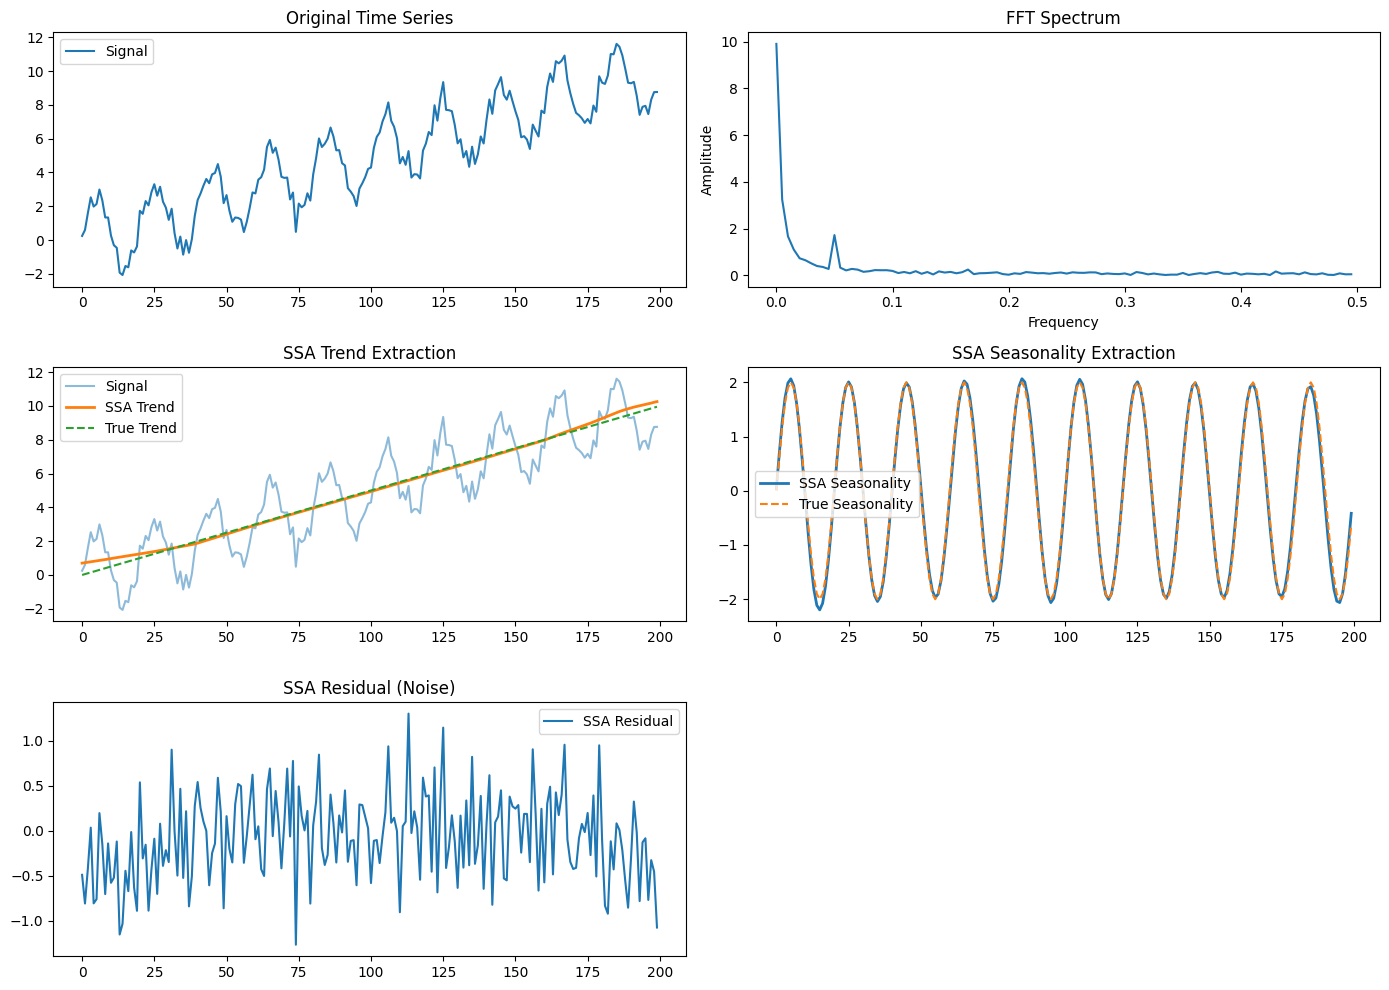

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq

# -----------------------
# Helper functions for SSA
# -----------------------
def embed_time_series(x, L):
    """Create trajectory (Hankel) matrix."""
    N = len(x)
    K = N - L + 1
    return np.column_stack([x[i:i+L] for i in range(K)])

def diagonal_averaging(X):
    """Reconstruct time series from Hankel matrix via diagonal averaging."""
    L, K = X.shape
    N = L + K - 1
    y = np.zeros(N)
    counts = np.zeros(N)
    
    for i in range(L):
        for j in range(K):
            y[i + j] += X[i, j]
            counts[i + j] += 1
    return y / counts

def ssa_decompose(x, L):
    """Perform SSA decomposition."""
    X = embed_time_series(x, L)
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    d = len(s)
    components = []
    for i in range(d):
        Xi = s[i] * np.outer(U[:, i], Vt[i, :])
        components.append(diagonal_averaging(Xi))
    return components, s

# -----------------------
# 1. Generate synthetic signal
# -----------------------
np.random.seed(42)
N = 200
t = np.arange(N)

trend = 0.05 * t                           # linear trend
seasonal = 2 * np.sin(2 * np.pi * t / 20)  # periodic component
noise = np.random.normal(0, 0.5, N)        # random noise
signal = trend + seasonal + noise

# -----------------------
# 2. FFT Analysis
# -----------------------
yf = fft(signal)
xf = fftfreq(N, 1)[:N//2]
fft_amplitude = 2.0/N * np.abs(yf[0:N//2])

# -----------------------
# 3. SSA Analysis
# -----------------------
L = 40  # window length
components, s = ssa_decompose(signal, L)

# Reconstruct groups: trend (first), seasonality (next two), residual = rest
trend_reconstructed = components[0]
season_reconstructed = components[1] + components[2]
residual = signal - (trend_reconstructed + season_reconstructed)

# -----------------------
# 4. Visualization
# -----------------------
plt.figure(figsize=(14, 10))

# Original signal
plt.subplot(3, 2, 1)
plt.plot(t, signal, label="Signal")
plt.title("Original Time Series")
plt.legend()

# FFT Spectrum
plt.subplot(3, 2, 2)
plt.plot(xf, fft_amplitude)
plt.title("FFT Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

# SSA - Trend
plt.subplot(3, 2, 3)
plt.plot(t, signal, label="Signal", alpha=0.5)
plt.plot(t, trend_reconstructed, label="SSA Trend", linewidth=2)
plt.plot(t, trend, '--', label="True Trend")
plt.title("SSA Trend Extraction")
plt.legend()

# SSA - Seasonality
plt.subplot(3, 2, 4)
plt.plot(t, season_reconstructed, label="SSA Seasonality", linewidth=2)
plt.plot(t, seasonal, '--', label="True Seasonality")
plt.title("SSA Seasonality Extraction")
plt.legend()

# SSA - Residual
plt.subplot(3, 2, 5)
plt.plot(t, residual, label="SSA Residual")
plt.title("SSA Residual (Noise)")
plt.legend()

plt.tight_layout()
plt.show()
